## Gradient based optimization methods

In [1]:
import notebook_importer
from utility import *
import numpy as np
from numpy import sqrt, sum, abs, max, maximum, logspace, exp, log, log10, zeros
from numpy.linalg import norm
from numpy.random import randn, rand
import urllib
import matplotlib.pyplot as plt
np.random.seed(0)

running importer
importing Jupyter notebook from utility.ipynb
Founds 2 cells


## Gradient descent

### Lipschitz Estimator
A method that estimates the Lipschitz constant of a function $g$.  This can be done using the formula
$$L \approx \frac{\|g(x) - g(y)\|}{\|x-y\|}.$$
The inputs should be a function $g:\mathbb{R}^n \to \mathbb{R}^m,$ and an initial vector $x$ in the domain of $g$.

In [2]:
def estimate_lipschitz(g, x):
    y = rand(*x.shape)
    L = norm(g(x)-g(y))/norm(x-y)
    return L

### A routine that minimizes a function using gradient descent.
The inputs $f$ and $grad$ are function handles.  The function $f: \mathbb{R}^N\to \mathbb{R}$ is an arbitrary objective function, and  $grad: \mathbb{R}^N \to \mathbb{R}^N$ is its gradient.  The method minimizes $f$ using gradient descent, and terminate when the gradient of $f$ is small.  

**Stopping condition:**
$$\|\nabla f(x^k)\|<\|\nabla f(x^0)\|*tol$$
 where $x^0$ is an initial guess and $tol$ is a small tolerance parameter (a typical value would be $10^{-4}$).  
 
  Use a backtracking line search to guarantee convergence.   The stepsize should be monotonically decreasing.  Each iteration should begin by trying the stepsize that was used on the previous iteration, and then backtrack until the Armijo condition holds:
  $$f(x^{k+1}) \le f(x^k) + \alpha \langle x^{k+1} - x^k, \nabla f(x^k)\rangle,$$
  where $\alpha \in (0,1),$ and $\alpha=0.1$ is suggested.

  The function returns the solution vector $x_{sol}$, and also a vector $res$ containing the norm of the residual (i.e., the norm of the gradient) at each iteration.

This initial stepsize should be $10/L$, where $L$ is an estimate of the Lipschitz constant for the gradient. We over-estimate the step size intially and tone it down using the line search condition.

In [3]:
def grad_descent(f, grad, x0, max_iters=10000, tol=1e-4):
    x_k = x0
    L = estimate_lipschitz(grad, x_k)
    step_size = 10/L
    res=[]
    res.append(norm(grad(x_k)))
    
    for i in range(max_iters):
        d = -grad(x_k)

        while(f(x_k + step_size*d)>=(f(x_k) + 0.1*(np.sum((step_size*d)*(-d))))):
            step_size = step_size/2
        x_k1 = x_k + step_size*d  
        res.append(norm((-d)))
        
        if res[-1] < tol*res[0]:
            x= x_k
            break
        x_k = x_k1     
        
    return x, res

Solver terminated in 269 steps and minimized the function


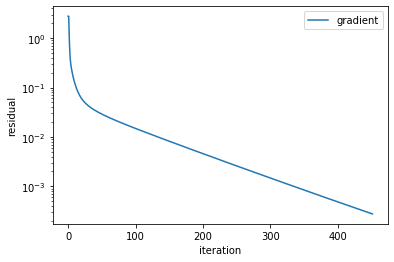

In [4]:
# Define a classification problem
X, y = create_classification_problem(100, 10, cond_number=10)
# Define the logistic loss function, and its gradient
f = lambda w: logreg_objective(w,X,y)
grad = lambda w: logreg_objective_grad(w,X,y)
# Pick the initial guess
w0 = zeros((10,1))

# Now, solve the minimization problem
w, res = grad_descent(f,grad,w0)

# Check the solution
assert res[-1]/res[0]<1e-4, "ERROR: Gradient descent routine did not the minimize the function"
print("Solver terminated in %d steps and minimized the function"%len(res))


_, res_g = grad_descent(f,grad,w0)
n_g = list(range(len(res_g)))
plt.semilogy(n_g,res_g)
plt.legend(('gradient',))
plt.xlabel('iteration')
plt.ylabel('residual')
plt.show()

### Gradient solver that begins each iteration using a Barzilai-Borwein stepsize (BB Method) 
  $$\tau = \frac{\langle x^{k+1} - x^k ,x^{k+1} - x^k   \rangle}{\langle x^{k+1} - x^k ,\nabla f(x^{k+1}) - \nabla f(x^k)   \rangle}.$$
 


In [5]:
def grad_descent_bb(f, grad, x0, max_iters=10000, tol=1e-4):
    x_k = x0
    L = estimate_lipschitz(grad, x0)
    step_size = L/100
    x_k1= x_k - step_size*grad(x_k)
    res = []
    res.append(norm(grad(x_k)))
    d = -grad(x_k)
    for i in range(max_iters):
        
        step_size = (np.sum((x_k1-x_k)*(x_k1 - x_k)))/(np.sum((x_k1 - x_k)*(grad(x_k1) +d)))        

        
        while(f(x_k + step_size*d)>=(f(x_k) + 0.1*step_size*(np.sum((d)*(-d))))):
            step_size = step_size/2        

        x_k = x_k1
        d = -grad(x_k)
        res.append(norm(d))
        x_k1 = x_k + step_size*d

        if(res[-1]<tol*res[0]):
            x= x_k
            break
        
    
    return x, res


Solver terminated in 46 steps and minimized the function


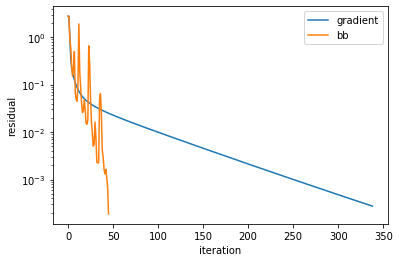

In [6]:
# Minimize that logistic loss again
f = lambda w: logreg_objective(w,X,y)
grad = lambda w: logreg_objective_grad(w,X,y)

w, res = grad_descent_bb(f,grad,w0)
assert res[-1]/res[0]<1e-4, "ERROR:  The BB routine did not the minimize the function"
print("Solver terminated in %d steps and minimized the function"%len(res))


_, res_g = grad_descent(f,grad,w0)
_, res_b = grad_descent_bb(f,grad,w0)
n_g = list(range(len(res_g)))
n_b = list(range(len(res_b)))

plt.semilogy(n_g,res_g,n_b,res_b)
plt.legend(('gradient','bb'))
plt.xlabel('iteration')
plt.ylabel('residual')
plt.show()

### A routine that uses Nesterov's accelerated gradient method
\begin{align}
x^{k} &= y^k - \tau \nabla f(y^k)\\
\delta^{k+1} &= \frac{1+\sqrt{1+4(\delta^k)^2}}{2}\\
y^{k+1} &= x^{k}+\frac{\delta^k-1}{\delta^{k+1}}(x^k-x^{k-1})
\end{align}
The stepsize restriction for Nesterov's methods is $\tau<1/L,$ however when $L$ is not known exactly you can use the line search condition
 $$f(x^k) \le f(y^{k}) + \alpha (x^k-y^k)^T\nabla f(y^k), $$
 where $\alpha \in [1/2,1).$  

In [7]:
def grad_descent_nesterov(f, grad, x0, max_iters=10000, tol=1e-4):
    L = estimate_lipschitz(grad, x0)
    step_size = 0.8/L
    delta_k =1 
    res = []
    y_k = x0
    x_k_prev = x0
    x_k = y_k - step_size*grad(y_k)
    res.append(norm(grad(x_k_prev)))
    for i in range(max_iters):
       
        d=-grad(y_k)
        #Armijo condition
        while(f(y_k+step_size*d)>=(f(y_k) + 0.5*(np.sum((step_size*d)*(-d))))):
            step_size = step_size/2        
        
        
        #Calculation for updates
        x_k = y_k - step_size*(-d)
        delta_k1 = (1 + np.sqrt(4*(delta_k**2) + 1))/2
        y_k1 = x_k + ((delta_k - 1)/(delta_k1))*(x_k - x_k_prev)
        
        #Updates
        delta_k = delta_k1
        x_k_prev = x_k
        y_k = y_k1
        res.append(norm(grad(x_k)))
        
        #Check for convergence
        if res[-1] < tol*res[0]:
            x= x_k
            break
      
    return x, res

Solver terminated in 225 steps and minized the function


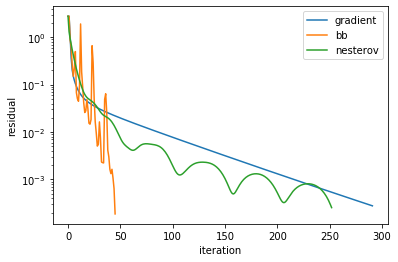

In [8]:
# Minimize the logistic loss using Nesterov's method

f = lambda w: logreg_objective(w,X,y)
grad = lambda w: logreg_objective_grad(w,X,y)

w, res = grad_descent_nesterov(f,grad,w0)
assert res[-1]/res[0]<1e-4, "ERROR: Nesterov routine did not the minimize the function"
print("Solver terminated in %d steps and minized the function"%len(res))


_, res_g = grad_descent(f,grad,w0)
_, res_b = grad_descent_bb(f,grad,w0)
_, res_n = grad_descent_nesterov(f,grad,w0)
n_g = list(range(len(res_g)))
n_b = list(range(len(res_b)))
n_n = list(range(len(res_n)))

plt.semilogy(n_g,res_g,n_b,res_b,n_n,res_n)
plt.legend(('gradient','bb','nesterov'))
plt.xlabel('iteration')
plt.ylabel('residual')
plt.show()


## Image denoising


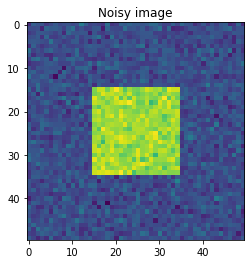

In [9]:
# Generate a noisy image
image = zeros((50,50))
image[15:35,15:35]=1
image = image+0.1*randn(50,50)
plt.title('Noisy image')
plt.imshow(image)
plt.show()

#### Total Variation (TV) objective to denoise an image

**TV objective**
$$ |\nabla x| + \frac{\mu}{2}\|x-f\|^2$$

Since L1 norm is not differentiable, we use hyperbolic regularization where
$$ h(x) = \sqrt{x^2+\epsilon ^2}$$

The objective becomes:
$$h(\nabla x) + \frac{\mu}{2}\|x-f\|^2$$

The derivative of this objective is :
$$ \nabla^{T}h'(\nabla x) + \mu(x-f)$$

where $$ h'(x) = \frac{x}{\sqrt{x^2 + \epsilon^2}}$$

In [10]:
# Gradient of the individual components of the objective
kernel_h = [[1,-1,0]] 
kernel_v = [[1],[-1],[0]]

def gradh(x):
    """Discrete gradient/difference in horizontal direction"""
    return convolve2d(x,kernel_h, mode='same', boundary='wrap')
def gradv(x):
    """Discrete gradient/difference in vertical direction"""
    return convolve2d(x,kernel_v, mode='same', boundary='wrap')
def grad2d(x):
    """The full gradient operator: compute both x and y differences and return them all.  The x and y 
    differences are stacked so that rval[0] is a 2D array of x differences, and rval[1] is the y differences."""
    return np.stack([gradh(x),gradv(x)])

def gradht(x):
    """Adjoint of gradh"""
    kernel_ht = [[0,-1,1]] 
    return convolve2d(x,kernel_ht, mode='same', boundary='wrap')
def gradvt(x):
    """Adjoint of gradv"""
    kernel_vt = [[0],[-1],[1]]
    return convolve2d(x,kernel_vt, mode='same', boundary='wrap')
def divergence2d(x):
    "The method is the adjoint of grad2d."
    return gradht(x[0])+gradvt(x[1])

In [11]:
# Using the individual components to create the complete gradient of the objective 

def h(z, eps=.01):
    """The hyperbolic approximation to L1"""
    return sum(sqrt(z*z+eps*eps).ravel())
def tv_denoise_objective(x,mu,b):
    return h(grad2d(x)) + 0.5*mu*norm(x-b)**2
def h_grad(z, eps=.01):
    """The gradient of h"""
    return z/sqrt(z*z+eps*eps)
def tv_denoise_grad(x,mu,b):
    """The gradient of the TV objective"""
    return divergence2d(h_grad(grad2d(x))) + mu*(x-b)

### Using the BB routine above to minimize the TV objective, and denoise the test image.

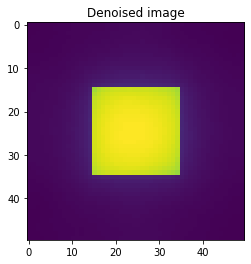

In [12]:
x0 = np.zeros(image.shape)
f = lambda x: tv_denoise_objective(x, mu=1, b=image)
grad = lambda x: tv_denoise_grad(x, mu=1, b=image)
x, res = grad_descent_bb(f, grad, x0)

plt.title("Denoised image")
plt.imshow(x)
plt.show()